### 3D Particle simulation, from H. Talbot

In [1]:
import matplotlib.pylab as plt
import numpy as np
import numpy.random
import scipy
import skimage
import pymrt as mrt
import raster_geometry as rg
#import pymrt.geometry


 ____        __  __ ____ _____
|  _ \ _   _|  \/  |  _ \_   _|
| |_) | | | | |\/| | |_) || |
|  __/| |_| | |  | |  _ < | |
|_|    \__, |_|  |_|_| \_\|_|
       |___/



In [2]:
# constants
def setParameters(shapeimg=350,# size of the image
                  radius=80, # radius of HR ball
                  step=0.1, # relative to 1
                  slices=7,# number of 2D samples
                  zoomfactor=0.1,
                  approxorder=1):
    return(shapeimg,radius,step,slices,zoomfactor,approxorder)

# globals, avoid using them
shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()

In [3]:
# perfect sphere
ball1=rg.sphere(shapeimg,radius,position=[0.5,0.7,0.7]).astype(float)
ball1.shape

(350, 350, 350)

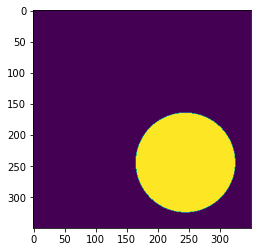

In [4]:
plt.figure()
plt.imshow(ball1[int(shapeimg/2),:,:])
plt.show()

In [5]:
## Random placement, then downsample
center=np.random.normal(loc=0.5,scale=step,size=3)

In [6]:
ball1=rg.sphere(shapeimg,radius,position=center).astype(float)
print("center=",center)

center= [0.32974242 0.64882752 0.45208776]


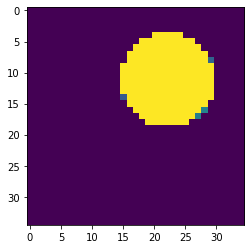

In [7]:
from scipy.ndimage.interpolation import zoom
smallball1=zoom(ball1,zoomfactor,order=1)
plt.figure()
plt.imshow(zoom(ball1[:,:,int(shapeimg*0.4)],zoomfactor,order=1))
plt.show()

In [8]:
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
#logging.debug('A debug message!')
#logging.info('We processed %d records', len(processed_records))

def sampleBall(debug=True):
    # parameters as local variables
    shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()
    
    n=slices
    slicelist = ((np.arange(n)-(n-1)/2)*(2*radius/n)+(shapeimg/2)).astype(int)
    logging.debug("slicelist=%s",str(slicelist))
    disklist = []
    centers = []
    for i in range(n):
        # create high resolution ball randomly shifted
        center=np.random.normal(loc=0.5,scale=step,size=3)
        logging.debug("center=%s",str(center))
        hrBall=rg.sphere(shapeimg,radius,position=center).astype(float)
        lrDisk=zoom(hrBall[slicelist[i],:,:],zoomfactor,order=approxorder)
        disklist.append(lrDisk)
        centers.append(center)
    return(centers,slicelist, np.array(disklist))

DEBUG:root:slicelist=[106 129 152 175 197 220 243]
DEBUG:root:center=[0.5676445  0.48771005 0.43393819]
DEBUG:root:center=[0.55116656 0.45758224 0.54205563]
DEBUG:root:center=[0.49245741 0.4883302  0.64679526]
DEBUG:root:center=[0.55098884 0.53889425 0.36788504]
DEBUG:root:center=[0.61257697 0.49576866 0.54745691]
DEBUG:root:center=[0.50785405 0.38685835 0.54977529]
DEBUG:root:center=[0.36633742 0.47392503 0.44498172]


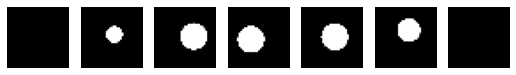

In [9]:
centers,slicelist,mysamples=sampleBall()
def imshown(imlist,cmap="gray"):
    w=10
    h=10
    fig=plt.figure(figsize=(9, 2))
    columns = len(imlist)
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imlist[i-1],cmap=cmap)
        plt.axis('off')

    plt.show()
    
imshown(mysamples,cmap="gray")

## Simulation and estimation

(350, 350, 350)


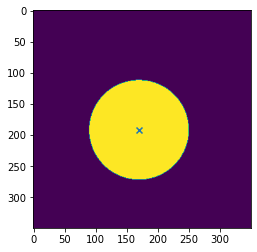

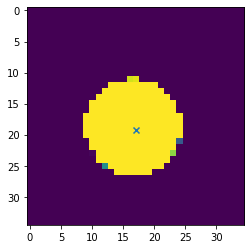

In [98]:
# Parameters

# Dimension of the 3D image
Nx,Ny,Nz = (350,350,350)

# Radius and center of the sphere
Radius = 80
np.random.seed(42)
center=np.random.normal(loc=0.5,scale=step,size=3)

# Particle simulation
# perfect sphere
ball =rg.sphere((Nx,Ny,Nz),Radius,position=center).astype(float)
print(ball.shape)

# Zoom
# Zoom factor
zoomfactor = 0.1
nx = int(zoomfactor*Nx)
ny = int(zoomfactor*Ny)
nz = int(zoomfactor*Nz)
R = Radius*zoomfactor


from scipy.ndimage.interpolation import zoom

particle = zoom(ball,zoomfactor,order=1)

plt.figure()
plt.imshow(ball[:,:,int(Nz*center[2])])
plt.scatter([Nx*center[1]],[Ny*center[0]], marker="x")
plt.show()


plt.figure()
plt.imshow(particle[:,:,int(nz*center[2])])
plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
plt.show()

# Diagonal of the frames
d = np.sqrt(nx**2+ny**2)

# z-coordinates of the frames
frames  = np.arange(0,nz)
# Number of frames
m = len(frames)


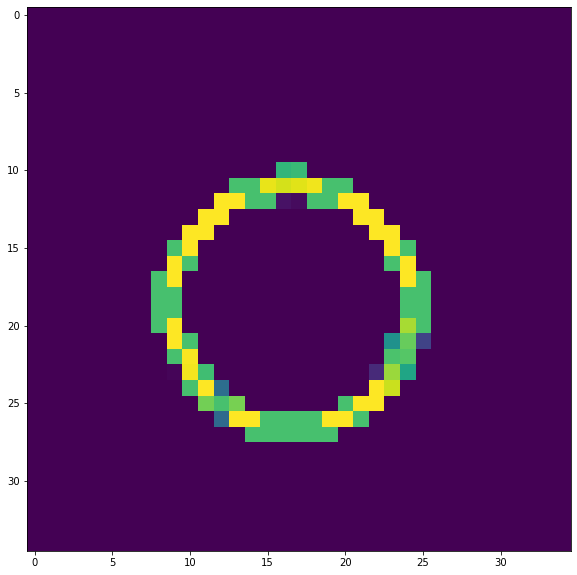

In [169]:
# Total variation 3D matrix of the image frames
def W_mat(image, frames):
    nx,ny,nz = image.shape
    W = np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            for k in frames:
                varX = 0
                varY = 0
                if i==0:
                    varX += (image[i+1,j,k]-image[i,j,k])**2
                elif i==nx-1:
                    varX += (image[i-1,j,k]-image[i,j,k])**2
                else:
                    varX += (image[i-1,j,k]-image[i,j,k])**2+(image[i+1,j,k]-image[i,j,k])**2
                if j==0:
                    varY += (image[i,j+1,k]-image[i,j,k])**2
                elif j==ny-1:
                    varY += (image[i,j-1,k]-image[i,j,k])**2
                else:
                    varY += (image[i,j-1,k]-image[i,j,k])**2+(image[i,j+1,k]-image[i,j,k])**2
                W[i,j,k] = np.sqrt(varX+varY)
    return W


plt.figure(figsize=(15,10))
plt.imshow(W_mat(particle,frames)[:,:,int(nz*center[2])])


In [111]:
# Objective function
def objective_function(image,frames):
    nx,ny,nz = image.shape
    m = len(frames)
    W = W_mat(image,frames)
    def obj(alpha,beta,gamma,xi,eta):
        res = 0
        for k in range(m):
            for i in range(nx):
                for j in range(ny):
                    res += W[i,j,frames[k]]*(-2*i*alpha -2*j*beta + xi - eta[k] +i**2+j**2)**2
        return res/2
    return obj



obj = objective_function(particle,frames)
print(obj(10,10,10,10,np.ones(m)))

7311993.319739506


In [112]:
# Keeping only frames intersecting the sphere

def intersecting_frames(image,frames):
    start = -1
    end = -1
    index = 0
    m = len(frames)
    while end<0 and index<m:
        M = np.amax(image[:,:,frames[index]])
        if M>0 and start<0:
            start = index
        if start >= 0 and M==0:
            end = index
        index+=1
    if end<0:
        end = m
    return frames[start:end]

print(intersecting_frames(particle, frames))
print(np.amax(particle[:,:,11]))
print(np.amax(particle[:,:,12]))


framesInter = intersecting_frames(particle, frames)
mInter = len(framesInter)
print(mInter)


[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
0.0
1.0
15


In [115]:
# Problem with cvxpy
import cvxpy as cp

# Variables

alpha = cp.Variable(1)
beta = cp.Variable(1)
gamma = cp.Variable(1)
xi = cp.Variable(1)
eta = cp.Variable(mInter)

# Objective
obj = objective_function(particle,framesInter)

objective = cp.Minimize(obj(alpha,beta,gamma,xi,eta))

# Constraints
constraints = [alpha**2+beta**2-xi <= 0, xi - d**2 <= 0, -eta <= 0, eta+(gamma-framesInter)**2 - R**2 <= 0]


# Problem
prob = cp.Problem(objective,constraints)


None


In [168]:
# Solving
prob.solve(solver = cp.ECOS, verbose = True, max_iters=100)

print("Optimal value", prob.value)
print("Status :", prob.status)

print("alpha = ", alpha.value) 
print("beta = ", beta.value) 
print("gamma = ", gamma.value) 

print("Real center: ", center*nx)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.856e-15  -5.604e+03  +3e+06  5e-01  2e-01  1e+00  2e+02    ---    ---    2  1  - |  -  - 
 1  +6.260e+03  +3.548e+02  +3e+06  5e-01  2e-01  1e+01  2e+02  0.0545  8e-01   1  1  1 |  0  0
 2  +3.461e+04  +2.767e+04  +3e+06  6e-01  3e-01  1e+02  1e+02  0.4898  6e-01   1  1  1 |  0  0
 3  +7.899e+04  +7.771e+04  +5e+05  9e-02  6e-02  3e+01  3e+01  0.8322  2e-02   1  1  1 |  0  0
 4  +1.198e+05  +1.189e+05  +2e+05  6e-02  5e-02  7e+01  9e+00  0.9157  3e-01   1  1  1 |  0  0
 5  +1.467e+05  +1.464e+05  +3e+04  2e-02  2e-02  8e+01  2e+00  0.9343  1e-01   1  1  1 |  0  0
 6  +1.481e+05  +1.478e+05  +3e+04  2e-02  2e-02  9e+01  1e+00  0.2641  6e-01   1  1  2 |  0  0
 7  +1.457e+05  +1.455e+05  +1e+04  2e-02  2e-02  1e+02  7e-01  0.8595  4e-01   1  2  1 |  0  0
 8  +1.476e+05  +1.476e+05  +2e+03  6e-03  6e-

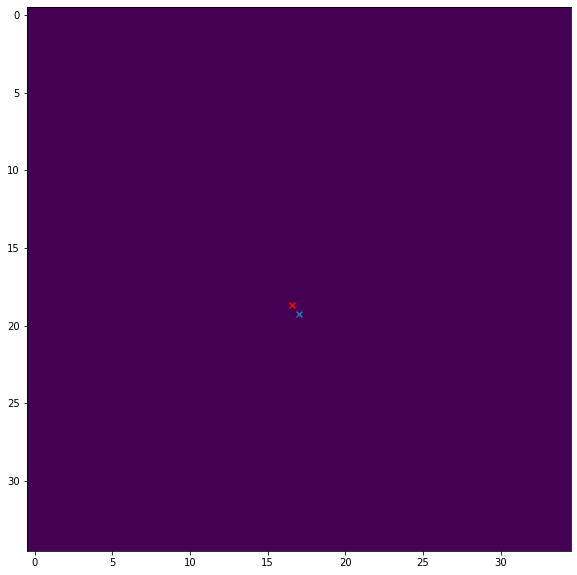

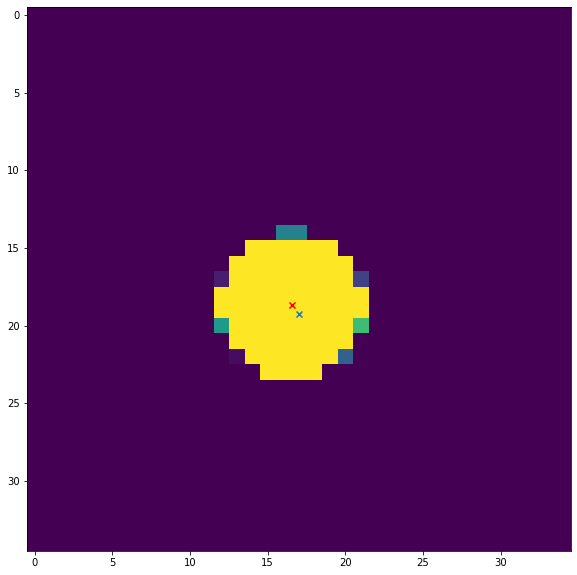

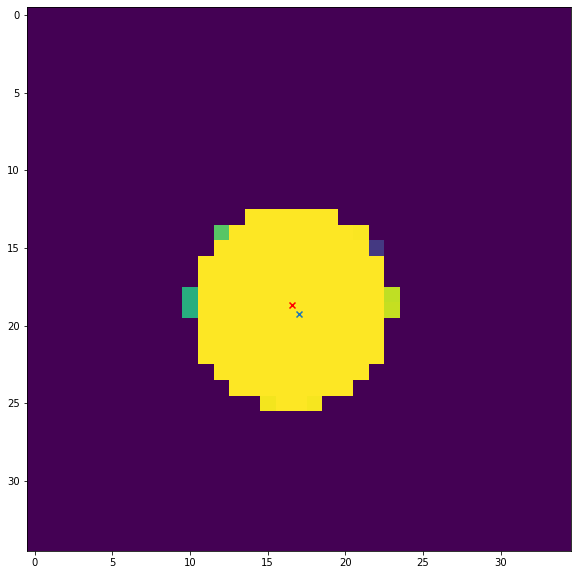

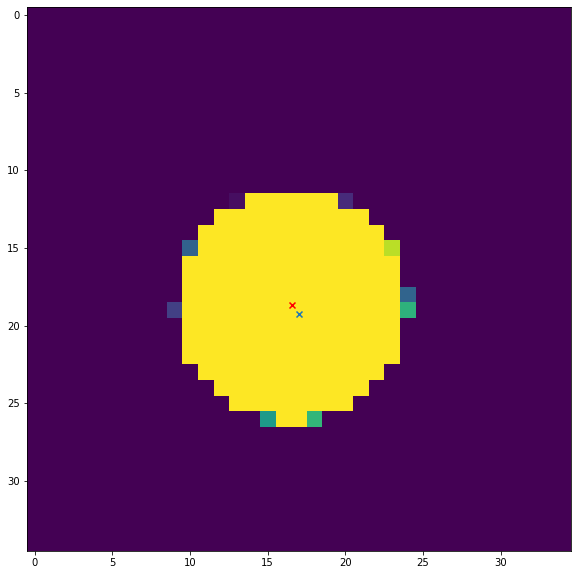

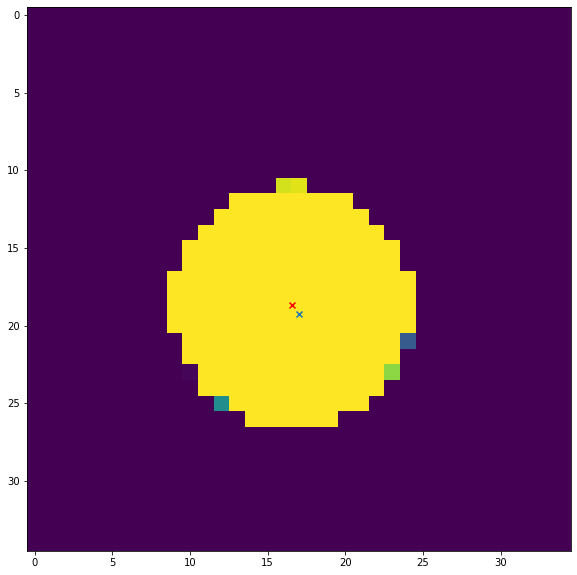

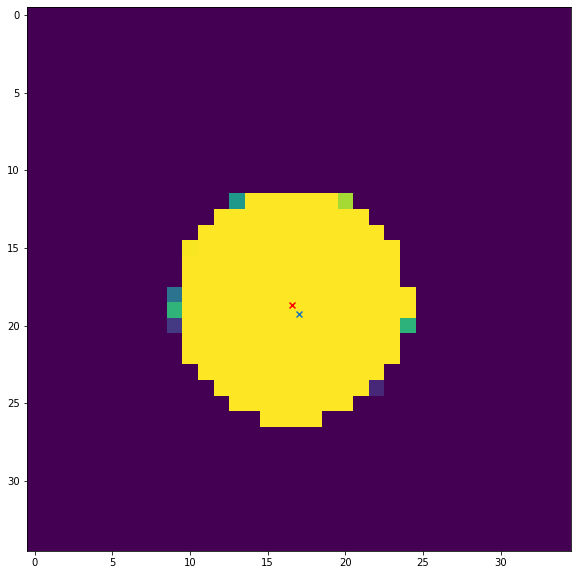

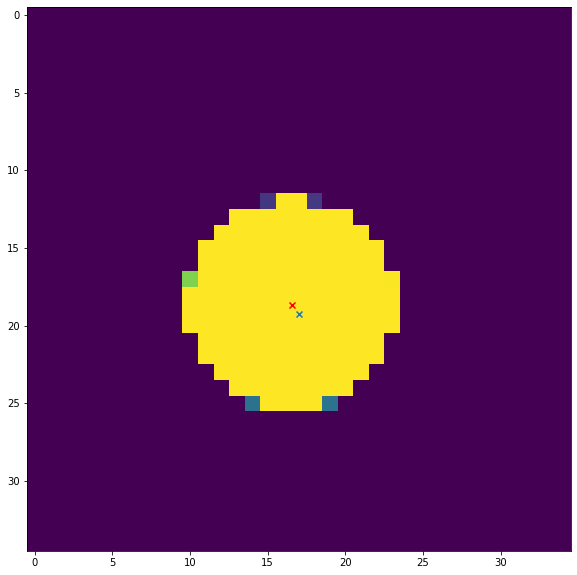

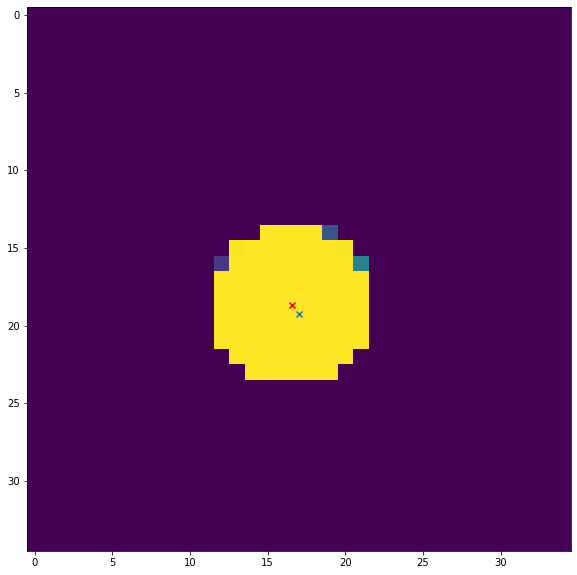

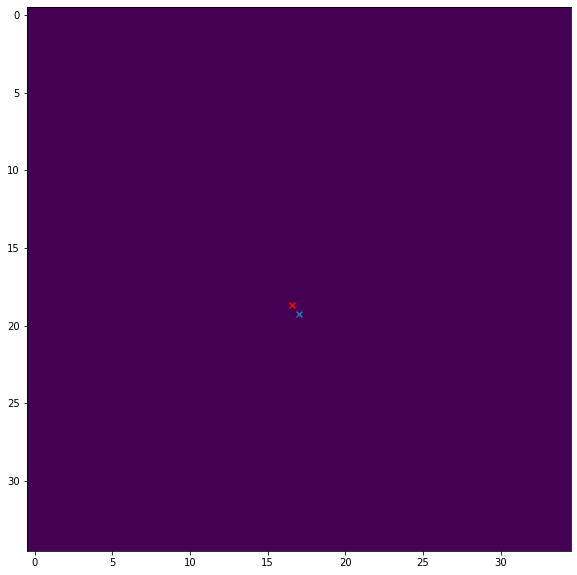

In [167]:
Z = int(nz*center[2])

for i in range(-8,9,2):
    plt.figure(figsize=(20,10))
    plt.imshow(particle[:,:,Z+i])
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([beta.value],[alpha.value], marker="x", color='red')
    plt.show()

In [11]:
import numpy as np
a = np.array([1])
b = [3]
c= np.ones(2)
np.concatenate((a,b,c))


array([1., 3., 1., 1.])

## Methode de Newton

In [591]:
import numpy as np
import matplotlib.pyplot as plt

# Centering step

# fonction à minimiser
def fct(listA, listb):
    m = len(listA)
    def f(v): 
        return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2
    return f

# v = np.concatenate((alpha, beta, gamma, xsi, eta))


# Fonction avec barrière:
def fct_bar(listA, listb, z, R, d, t): # t est le paramètre de barrière
    m = len(listA)
    def f(v):
        constr1 = v[4:]
        constr2 = -(v[4:] + (v[2]-z)**2 - R**2)
        constr3 = [-(v[0]**2 + v[1]**2 - v[3])]
        constr4 = [-(v[3] - d**2)]
        constr = np.concatenate((constr1,constr2,constr3,constr4))
        if np.min(constr) <= 0:
            #raise NameError("v non admissible")
            return np.inf
        else:
            return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2 - (1/t)*np.sum(np.log(constr))
    return f



# Gradient en v de la fonction à minimiser
def grad_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@(listA[i]@v - listb[i]) for i in range(m)])
    bar = np.zeros(n)
    # terme dû à la fonction barrière pour constr3 et constr4
    x = (-(v[0]**2 + v[1]**2 - v[3]))
    bar[0] += -2*v[0]/x
    bar[1] += -2*v[1]/x
    bar[3] += 1/x - 1/(d**2-v[3])
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = R**2 - u - (v[2]-z[j-4])**2
        bar[2] += -2*(v[2]-z[j-4])/x
        bar[j] += 1/u - 1/x   
    return res - bar/t



# Hessienne
def hess_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@listA[i] for i in range(m)])
    bar = np.zeros((n,n))
    x = (v[0]**2 + v[1]**2 - v[3])**2
    bar[0,0] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[0]**2)/x
    bar[1,1] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[1]**2)/x
    bar[3,3] += -1/x - 1/(v[3]-d**2)**2
    b = -4*v[0]*v[1]/x
    bar[0,1] += b
    bar[1,0] += b
    b = 2*v[0]/x
    bar[0,3] += b
    bar[3,0] += b
    b = 2*v[1]/x
    bar[1,3] += b
    bar[3,1] += b
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = (R**2 - u - (v[2]-z[j-4])**2)**2
        bar[2,2] += (-2*(R**2 - u - (v[2]-z[j-4])**2) - 4*(v[2]-z[j-4])**2)/x
        bar[j,j] += -1/u**2 - 1/x
        b = 2*(v[2]-z[j-4])/x
        bar[2,j] += b
        bar[j,2] += b
    return  res - bar/t





# Backtracking line search
def lineSearch(f,x,delta,grad,alpha,beta,t=1): # 0<alpha<1/2 et 0<beta<1
    while f(x+t*delta) >= f(x) + alpha*t*(grad.T@delta) :
        t = beta*t
        #print(f(x+t*delta) - (f(x) + alpha*t*(grad.T@delta)))
    return t

# Centering step
# On retourne la liste des points et des decr pour les graphes à la fin
def centering_step(listA, listb, z, R, d, t, v0, crit, alpha = 0.4, beta = 0.9): # t et eps > 0
    # méthode de Newton
    res = [v0]
    v = v0
    decr = np.inf
    liste_decr=[]
    f = fct_bar(listA, listb, z, R, d, t)
    grad = grad_f(listA, listb, z, R, d, t, v)
    hess = hess_f(listA, listb, z, R, d, t, v)
    hess_inv = np.linalg.inv(hess)
    delta = -hess_inv@grad
    decr = grad.T@hess_inv@grad
    while decr/2 >= crit:
        v = v + lineSearch(f,v,delta,grad,alpha,beta)*delta
        res.append(v)
        grad = grad_f(listA, listb, z, R, d, t, v)
        hess = hess_f(listA, listb, z, R, d, t, v)
        hess_inv = np.linalg.inv(hess)
        delta = -hess_inv@grad
        decr = grad.T@hess_inv@grad
        liste_decr.append(decr)
        #print("decr = ",decr)
        print(delta)
        print("v_cent = ",v)
        #print("f_bar(v_cent) = ",f(v))
    return (res,liste_decr)


# Barrier method
# On retourne la liste des points et des decr pour les graphes à la fin
def barr_method(listA, listb, z, R, d, v0,eps, crit, alpha =0.4, beta = 0.9, t0 = 1, mu = 10): # t0, mu et eps > 0
    res = [v0]
    liste_decr = []
    n = len(v0)
    v = v0
    t = t0
    while n/t >= eps:
        print("v = ",v)
        print("f(v) = ",fct(listA,listb)(v))
        (v, liste_decr_centering) = centering_step(listA, listb, z, R, d, t, v,crit, alpha, beta)
        liste_decr+= liste_decr_centering
        t = mu*t
        res = res + v
        v = v[-1]
    return (res,liste_decr)

In [596]:
#test

n = 8
listA = [np.eye(n)]

listA[0][2,2]=0
listA[0][0,0]=0
listA[0][1,1]=0
b = np.ones(n)*10
b[2]=0

listb = [b]
R=50
d=60
z = np.zeros(n-4)
v0 = np.ones(n)*5
v0[3]=150

eps=0.001
crit=100

print(barr_method(listA, listb, z, R, d, v0,eps,crit,t0=10,mu=10)[0][-1])

v =  [  5.   5.   5. 150.   5.   5.   5.   5.]
f(v) =  9950.0
[ -2.68502809  -2.68502809  -1.70498168 -49.81418155   8.74881956
   8.74881956   8.74881956   8.74881956]
v_cent =  [  1.60479404   1.60479404  -1.68026392 120.10364228   9.84178795
   9.84178795   9.84178795   9.84178795]
[  1.02319135   1.02319135  -4.43824266 -55.18949021   9.66287016
   9.66287016   9.66287016   9.66287016]
v_cent =  [-1.08023405 -1.08023405 -3.3852456  70.28946073 18.5906075  18.5906075
 18.5906075  18.5906075 ]
[-0.26909424 -0.26909423 -4.09344619  5.91381329 -4.22603729 -4.22603729
 -4.22603729 -4.22603729]
v_cent =  [-0.05704269 -0.05704269 -7.82348826 15.09997052 28.25347766 28.25347766
 28.25347766 28.25347766]


KeyboardInterrupt: 